In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install librosa==0.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import glob
import numpy as np
import librosa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
data_paths = ["/content/drive/MyDrive/Audio_clf_project/train_vocal/Subak1s", "/content/drive/MyDrive/Audio_clf_project/train_vocal/No_Subak1s"]
# 클래스 개수
num_classes = 2
# 각 클래스당 샘플 개수
num_samples = 169

In [5]:
def preprocess_data(data_paths, num_classes, num_samples, pad_value=-80.0):
    dataset = []
    labels = []
    max_time_steps = 0

    for class_index, data_path in enumerate(data_paths):
        wav_files = glob.glob(os.path.join(data_path, "*.wav"))

        for i in range(num_samples):
            audio, _ = librosa.load(wav_files[i], sr=None, mono=True)  # 각 1초파일

            spectrogram = librosa.feature.melspectrogram(audio, sr=44100)  #1초당 44100hz
            spectrogram = librosa.power_to_db(spectrogram, ref=np.max)    #데시벨로 변환, 사람의 청각 특성에 맞추기 위해

            max_time_steps = max(max_time_steps, spectrogram.shape[1])

            dataset.append(spectrogram)
            labels.append(class_index)

    padded_dataset = []
    for spectrogram in dataset:
        padded_spectrogram = np.pad(spectrogram, ((0, 0), (0, max_time_steps - spectrogram.shape[1])), mode='constant', constant_values=pad_value)
        padded_dataset.append(padded_spectrogram)

    dataset = np.array(padded_dataset)
    labels = np.array(labels)

    indices = np.arange(len(dataset))
    np.random.shuffle(indices)
    dataset = dataset[indices]
    labels = labels[indices]

    return dataset, labels

In [6]:
dataset, labels = preprocess_data(data_paths, num_classes, num_samples)

<ipython-input-5-6e8b8cf9ed46>:12: FutureWarning: Pass y=[-0.0017395  -0.00164795 -0.00167847 ... -0.02301025 -0.00668335
  0.01547241] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectrogram = librosa.feature.melspectrogram(audio, sr=44100)
<ipython-input-5-6e8b8cf9ed46>:12: FutureWarning: Pass y=[ 0.01443481  0.0140686   0.01507568 ... -0.01898193 -0.01800537
 -0.01141357] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectrogram = librosa.feature.melspectrogram(audio, sr=44100)
<ipython-input-5-6e8b8cf9ed46>:12: FutureWarning: Pass y=[ 0.01022339  0.01217651  0.01425171 ... -0.00238037 -0.00485229
 -0.00790405] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectrogram = librosa.feature.melspectrogram(audio, sr=44100)
<ipython-input-5-6e8b8cf9ed46>:12: FutureWarning: Pass y=[0.03039551 0.034729   0.03564453 ... 0.01022339 0.0

In [10]:
 #데이터셋 분할
train_ratio = 0.8
num_train_samples = int(num_samples * num_classes * train_ratio)

x_train = dataset[:num_train_samples]
x_test = dataset[num_train_samples:]

y_train = labels[:num_train_samples]
y_test = labels[num_train_samples:]

In [8]:
#
input_shape = x_train[0].shape

#x_train = x_train.reshape(-1, input_shape[0], input_shape[1], 1)
#x_test = x_test.reshape(-1, input_shape[0], input_shape[1], 1)

In [11]:
# 모델 구조 변경
model = Sequential()
input_shape = x_train[0].shape

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape + (1,)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(kernel_size=2, filters=32, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(kernel_size=2, filters=64, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(kernel_size=2, filters=128, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 126, 85, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 42, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 42, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 41, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 20, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 31, 20, 32)       

In [14]:
# 모델 훈련
batch_size = 70
epochs = 100

history=model.fit(x_train, y_train,
          batch_size=batch_size,
          steps_per_epoch=len(x_train) // batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))



Epoch 1/100
3/3 [==============================] - 0s 89ms/step - loss: 0.7029 - accuracy: 0.5238 - val_loss: 0.6870 - val_accuracy: 0.6029
Epoch 2/100
3/3 [==============================] - 0s 78ms/step - loss: 0.7208 - accuracy: 0.4600 - val_loss: 0.6883 - val_accuracy: 0.6912
Epoch 3/100
3/3 [==============================] - 0s 98ms/step - loss: 0.6928 - accuracy: 0.5750 - val_loss: 0.6905 - val_accuracy: 0.6471
Epoch 4/100
3/3 [==============================] - 0s 113ms/step - loss: 0.7019 - accuracy: 0.4900 - val_loss: 0.6915 - val_accuracy: 0.6029
Epoch 5/100
3/3 [==============================] - 0s 43ms/step - loss: 0.6955 - accuracy: 0.4810 - val_loss: 0.6918 - val_accuracy: 0.5735
Epoch 6/100
3/3 [==============================] - 0s 40ms/step - loss: 0.6922 - accuracy: 0.5100 - val_loss: 0.6921 - val_accuracy: 0.5294
Epoch 7/100
3/3 [==============================] - 0s 36ms/step - loss: 0.6957 - accuracy: 0.5000 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 8/100
3/3 [==

In [15]:
# 테스트 데이터 평가
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

3/3 [==============================] - 0s 6ms/step - loss: 0.0207 - accuracy: 1.0000
Test Loss: 0.02074364759027958
Test Accuracy: 1.0


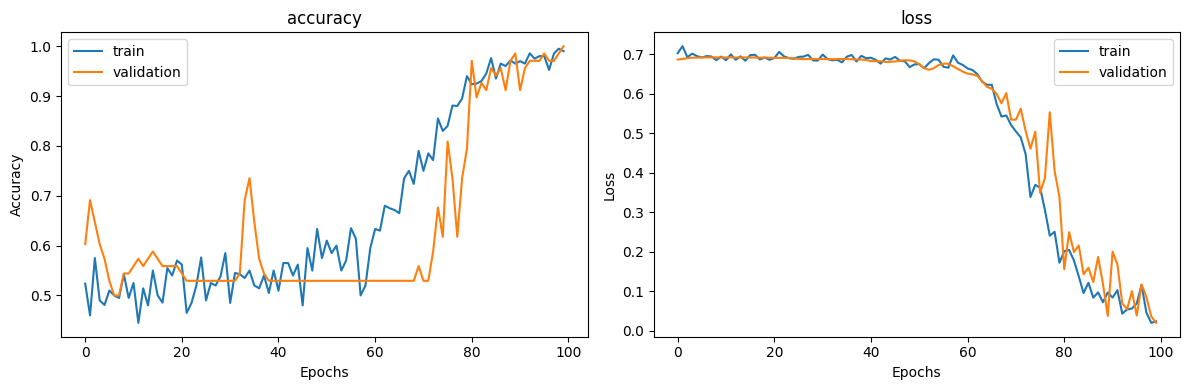

In [16]:
import matplotlib.pyplot as plt

def plot_history(history):
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx, key in enumerate(key_value):
        plt.subplot(1, len(key_value), idx+1)
        # 시각화 함수 호출
        plt.plot(history.history[key])
        plt.plot(history.history['val_' + key])
        plt.title(key+'')
        plt.xlabel('Epochs')
        plt.ylabel(key.capitalize())
        plt.legend(['train', 'validation'])
    plt.tight_layout()
    plt.show()

plot_history(history)

In [ ]:
model.save("/content/drive/MyDrive/Audio_clf_project/model/SUBAK_softmax")